In [76]:
import numpy as np

from kl.utils import load_fx
X, y = load_fx(data_start=0, data_end=5000, shift=1)

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim

# Encoder network
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2_mean = nn.Linear(128, latent_dim)
        self.fc2_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        z_mean = self.fc2_mean(h)
        z_logvar = self.fc2_logvar(h)
        return z_mean, z_logvar

# Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))  # Use sigmoid for binary data
        return x_recon

# Classifier network for latent space
# class Classifier(nn.Module):
#     def __init__(self, latent_dim, num_classes):
#         super(Classifier, self).__init__()
#         self.fc1 = nn.Linear(latent_dim, num_classes)
# 
#     def forward(self, z):
#         return self.fc1(z)

# Classifier works on latent dimension !    
class Classifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        h = torch.relu(self.fc2(h))
        return self.fc3(h)  # No softmax, CrossEntropyLoss applies it    

# VAE model combining Encoder, Decoder, and Classifier
class VAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, num_classes):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim)
        self.classifier = Classifier(latent_dim, num_classes)

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_recon = self.decoder(z)
        y_pred = self.classifier(z)  # Predicted class labels from latent space
        return x_recon, z_mean, z_logvar, y_pred

# Loss function for VAE and Classification
def loss_function(x_recon, x, z_mean, z_logvar, y_pred, y, beta=1, lambda_class=1):
    # Reconstruction loss (e.g., MSE or BCE)
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    
    # Classification loss (cross-entropy)
    class_loss = nn.functional.cross_entropy(y_pred, y)
    
    # Total loss
    # total_loss = recon_loss + 1/beta * kl_loss + 1/lambda_class * class_loss
    total_loss = recon_loss + beta * kl_loss + lambda_class * class_loss
    return total_loss, recon_loss, kl_loss, class_loss

# Training loop
def train_vae(model, dataloader, optimizer, scheduler, num_epochs=10, beta=1, lambda_class=1):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            x_recon, z_mean, z_logvar, y_pred = model(x)
            # beta = min(1, epoch / 100)+0.1  # Gradually increase beta up to 1 over the first 100 epochs
            # lambda_class = 1+epoch/10
            
            total_loss, recon_loss, kl_loss, class_loss = loss_function(x_recon, x, z_mean, z_logvar, y_pred, y, beta, lambda_class)
            loss = class_loss 
            # loss = total_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 100 == 0:
            print(f'Epoch {epoch + 1}, kl: {kl_loss:.4f}, class: {class_loss:.4f}, lr: {scheduler.get_last_lr()[0]:.6f}, lambda: {lambda_class:.2f}')
            # print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader.dataset)}')
        scheduler.step()
# Example usage
vae_model = VAE(input_dim=8, output_dim = 8, latent_dim=2, num_classes=2)  # Assuming 4 features, 2 classes
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=400, T_mult=1)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer,total_iters=5000)

In [78]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Assuming you already have your data loaded as X, y
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a DataLoader for batching
batch_size = 64
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model with the dataloader
train_vae(vae_model, dataloader, optimizer, scheduler, num_epochs=5000, beta=1, lambda_class=1)

Epoch 1, kl: 9.4464, class: 0.6961, lr: 0.001000, lambda: 1.00
Epoch 101, kl: 705.7957, class: 0.6371, lr: 0.000980, lambda: 1.00
Epoch 201, kl: 985.2971, class: 0.5257, lr: 0.000960, lambda: 1.00
Epoch 301, kl: 1099.9825, class: 0.4384, lr: 0.000940, lambda: 1.00
Epoch 401, kl: 1128.3966, class: 0.4236, lr: 0.000920, lambda: 1.00
Epoch 501, kl: 1305.6010, class: 0.6045, lr: 0.000900, lambda: 1.00
Epoch 601, kl: 1381.9120, class: 0.5564, lr: 0.000880, lambda: 1.00
Epoch 701, kl: 1449.9589, class: 0.3927, lr: 0.000860, lambda: 1.00
Epoch 801, kl: 1694.1736, class: 0.4647, lr: 0.000840, lambda: 1.00
Epoch 901, kl: 1673.7057, class: 0.3610, lr: 0.000820, lambda: 1.00
Epoch 1001, kl: 1733.5509, class: 0.3948, lr: 0.000800, lambda: 1.00
Epoch 1101, kl: 1541.3501, class: 0.3040, lr: 0.000780, lambda: 1.00
Epoch 1201, kl: 1731.6449, class: 0.4185, lr: 0.000760, lambda: 1.00
Epoch 1301, kl: 1674.6372, class: 0.3733, lr: 0.000740, lambda: 1.00
Epoch 1401, kl: 1720.4374, class: 0.4502, lr: 0.000

In [79]:
def infer_vae(model, x_new):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to calculate gradients during inference
        # Encode the input to get latent vector z
        z_mean, z_logvar = model.encoder(x_new)
        z_new = model.reparameterize(z_mean, z_logvar)
        
        # Reconstruct the input from latent vector z
        x_reconstructed = model.decoder(z_new)
        
        # Predict class from the latent vector z (optional)
        y_pred = model.classifier(z_new)
        predicted_class = torch.argmax(y_pred, dim=1)  # Get the class with highest probability
        
        return x_reconstructed, predicted_class

# Example usage
X_new, y_new = load_fx(data_start=0, data_end=6000, shift=1)
# X_new = X_new[0:6055]
# y_new = y_new[0:6055]
X_new_tensor = torch.tensor(X_new, dtype=torch.float32)  # X_new is your new input data
x_reconstructed, predicted_class = infer_vae(vae_model, X_new_tensor)

# print("Reconstructed Data:", x_reconstructed)
# print("Predicted Class:", predicted_class)

In [80]:
predicted_class_value = predicted_class.detach().numpy().astype(np.float32)
print(f'Class Mean: {np.mean(predicted_class_value)}')

Class Mean: 0.5121870040893555


In [81]:
import numpy as np
x_reconstructed_value = x_reconstructed.detach().numpy()
np.savetxt("x_reconstructed_value.txt", x_reconstructed_value)

In [82]:
np.savetxt("y.txt", y_new)

In [83]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
acc = accuracy_score(y_new, predicted_class_value)
print(f"Accuracy: {acc}")

Accuracy: 0.8449081803005009


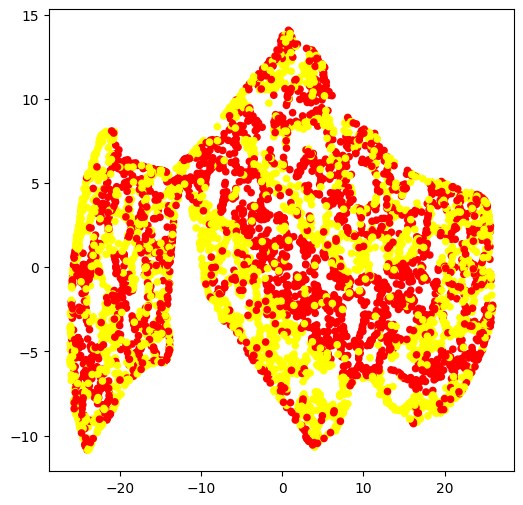

In [84]:
import pacmap
import numpy as np
import matplotlib.pyplot as plt

# loading preprocessed coil_20 dataset
# you can change it with any dataset that is in the ndarray format, with the shape (N, D)
# where N is the number of samples and D is the dimension of each sample
Xr = x_reconstructed_value
Xr = Xr.reshape(X_new.shape[0], -1)
# y = np.load("./data/coil_20_labels.npy", allow_pickle=True)

# initializing the pacmap instance
# Setting n_neighbors to "None" leads to an automatic choice shown below in "parameter" section
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(Xr, init="pca")
# X_transformed = embedding.fit_transform(Xr, init=None)

# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="autumn", c=y_new, s=20)


In [85]:
np.savetxt('X_transformed.txt', X_transformed)

In [86]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri